In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import malariagen_data

In [15]:
# define a function to extend segments
def extend_segments(df, min_size, min_gap, iterations=1):
    merged_rows = []
    i = 0
    for it in range(iterations):
      while i < len(df)-1:
          # check if the two segments are adjacent and meet the size requirement
          if (df.iloc[i+1]['start'] - df.iloc[i]['end'] <= min_gap) and (df.iloc[i]['size'] + df.iloc[i+1]['size'] >= min_size):
              merged_rows.append({
                  'contig': df.iloc[i]['contig'],
                  'index1': df.iloc[i]['index1'],
                  'index2': df.iloc[i]['index2'],
                  'start': df.iloc[i]['start'],
                  'end': df.iloc[i+1]['end'],
                  'size': df.iloc[i]['size'] + df.iloc[i+1]['size'],
                  'n_snps': df.iloc[i]['n_snps'] + df.iloc[i+1]['n_snps']
              })
              i += 2
          else:
              merged_rows.append({
                  'contig': df.iloc[i]['contig'],
                  'index1': df.iloc[i]['index1'],
                  'index2': df.iloc[i]['index2'],
                  'start': df.iloc[i]['start'],
                  'end': df.iloc[i]['end'],
                  'size': df.iloc[i]['size'],
                  'n_snps': df.iloc[i]['n_snps']
              })
              i += 1
      if i == len(df)-1:
          merged_rows.append({
              'contig': df.iloc[i]['contig'],
              'index1': df.iloc[i]['index1'],
              'index2': df.iloc[i]['index2'],
              'start': df.iloc[i]['start'],
              'end': df.iloc[i]['end'],
              'size': df.iloc[i]['size'],
              'n_snps': df.iloc[i]['n_snps']
          })
      # create a new dataframe with the merged rows
      df = pd.DataFrame(merged_rows, columns=['contig', 'index1', 'index2', 'start', 'end', 'size', 'n_snps'])
      print(f"iteration {it} - {df.shape}")
    return df

def plot_ibd_segments(ax, contig, ibd1_df, ibd2_df, title=None, figsize=(12,2)):
    from matplotlib.lines import Line2D
    import matplotlib.pyplot as plt
    from matplotlib import ticker
    
    contig_len = ag3.genome_sequence(contig).shape[0]

    y_pos = np.linspace(0.05, 1, contig_len)
    
    ax.set_xlim(0, contig_len)
    ax.set_yticks([])
    print("plotting now")
    for i, (x,y) in enumerate(zip(ibd1_df.index1.unique(), ibd1_df.index2.unique())):
        for _, row in ibd1_df.query("index1 == @x and index2 == @y").iterrows():
            line_height = y_pos[i]

            start, end = row[['start', 'end']]
            ibd_line = Line2D(xdata=(start, end), ydata=(line_height, line_height), color='grey')
            ax.add_line(ibd_line)

            for _, row in ibd2_df.query("index1 == @x and index2 == @y").iterrows():
                start, end = row[['start', 'end']]
                ibd_line = Line2D(xdata=(start, end), ydata=(line_height, line_height))
                ax.add_line(ibd_line)   

    if title: ax.set_title(title)
    ax.set_xticks(np.arange(0, contig_len, 10e6))
    # Use the FuncFormatter class to set the tick labels
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

    sns.despine(ax=ax, left=True)


# Define a function to format the tick labels
def format_func(value, tick_number):
    # Convert the tick value from bytes to megabytes
    mb_value = value / 1e6
    # Format the tick label as a string with 1 decimal place and the "Mb" suffix
    return f"{mb_value:.1f} Mb"

In [44]:
def summarise_ibd_data(prefix='coluzzii', ibd1_min_size=10000, ibd2_min_size=100):
    from dask import dataframe as dd
    import malariagen_data
    
    ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)
    genome_size = np.sum([ag3.genome_sequence(contig).shape[0] for contig in ag3.virtual_contigs + ('X',)])

    ibd1_list = []
    ibd2_list = []
    for i, contig in enumerate(ag3.virtual_contigs + ('X',)):
        print(f"reading ibd1 {contig}...")
        ibd1_df = dd.read_csv(f"{prefix}.{contig}.ibd1.tsv", sep="\t").query(f"n_snps > {ibd1_min_size}")
        print(f"reading ibd2 {contig}...")
        ibd2_df = dd.read_csv(f"{prefix}.{contig}.ibd2.tsv", sep="\t").query(f"n_snps > {ibd2_min_size}")
        
        ibd1_data = ibd1_df.groupby(['index1', 'index2']).agg({'size':'sum', 'n_snps':'sum'}).assign(contig=contig)
        ibd2_data = ibd2_df.groupby(['index1', 'index2']).agg({'size':'sum', 'n_snps':'sum'}).assign(contig=contig)
        ibd1_list.append(ibd1_data)
        ibd2_list.append(ibd2_data)
    
    print("computing...")
    ibd1_stats = dd.concat(ibd1_list).compute()
    ibd2_stats= dd.concat(ibd2_list).compute()
    
    ibd1_stats.to_csv("ibd1.per_contig.tsv", sep="\t")
    ibd2_stats.to_csv("ibd2.per_contig.tsv", sep="\t")
    
    ibd1_stats = ibd1_stats.reset_index().rename(columns={'size':'ibd1_size'}).groupby(['index1', 'index2']).agg({'ibd1_size':'sum'}).assign(ibd1_fraction=lambda x: x['ibd1_size']/genome_size)
    ibd2_stats = ibd2_stats.reset_index().rename(columns={'size':'ibd2_size'}).groupby(['index1', 'index2']).agg({'ibd2_size':'sum'}).assign(ibd2_fraction=lambda x: x['ibd2_size']/genome_size)
    ibd_stats = pd.concat([ibd1_stats, ibd2_stats], axis=1)
    
    ibd_stats.to_csv("ibd.summary.tsv", sep="\t")
    return ibd_stats

In [20]:
ibd1_stats, ibd2_stats = summarise_ibd_data()

reading ibd1 2RL...
reading ibd2 2RL...
aggregating ibd1
aggregating ibd2
reading ibd1 3RL...
reading ibd2 3RL...
aggregating ibd1
aggregating ibd2
reading ibd1 X...
reading ibd2 X...
aggregating ibd1
aggregating ibd2
computing...


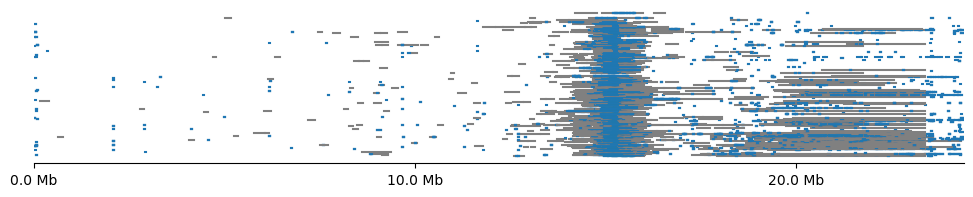

In [8]:
fig = plot_ibd_segments(ibd1_df.query("n_snps > 10000").sort_values("size", ascending=False), ibd2_df)